In [1]:
import contextily as cx
import matplotlib.pyplot as plt
import geopandas as gpd

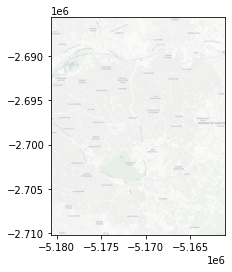

In [2]:
areas = [
    'Centro',   
    'Oeste',
    'Sul1',
    'Sul2',
    'Norte1',
    'Norte2',
    'Leste1',
    'Leste2'
]

for area in areas:
    db = gpd.read_file(f"../new_maps/{area}_modified/{area}_modified.shp")

    w, s, e, n = db.total_bounds
    img, ext = cx.bounds2raster(w, s, e, n, f"../raster_maps/{area}.tiff", source=cx.providers.CartoDB.Positron, ll=True)

    plt.imshow(img, extent=ext)
